<a href="https://colab.research.google.com/github/tarumi283/tarumi/blob/main/cosinor_phase_ana_latest%20edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For RLU (linear grid search): Refined T = 48.00 h, MESOR = 3689.95, Amplitude = 124.23, Phase = 1.10
Nonlinear fit for RLU: T = 48.00 h, MESOR = 3689.95, Amplitude = 124.23, Phase = 1.10


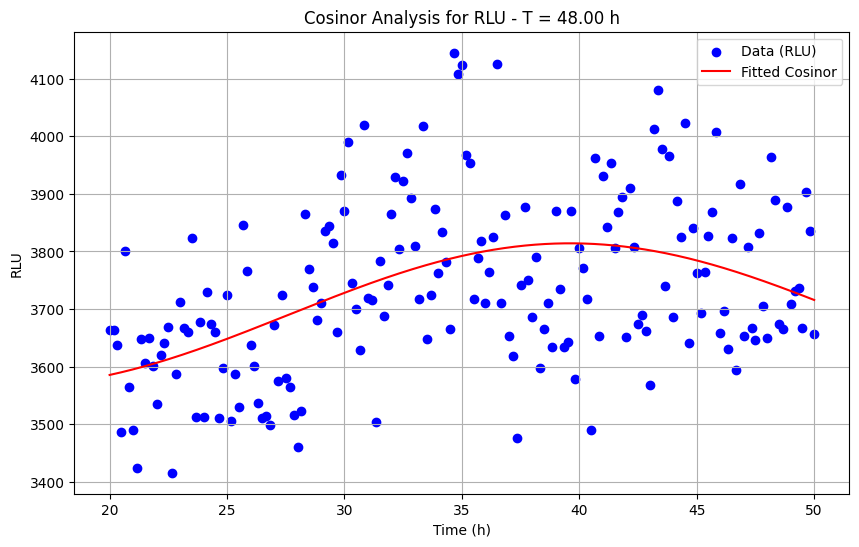

For RLU.1 (linear grid search): Refined T = 21.79 h, MESOR = 51.37, Amplitude = 497.04, Phase = 1.04
Nonlinear fit for RLU.1: T = 21.79 h, MESOR = 51.38, Amplitude = 497.00, Phase = 1.03


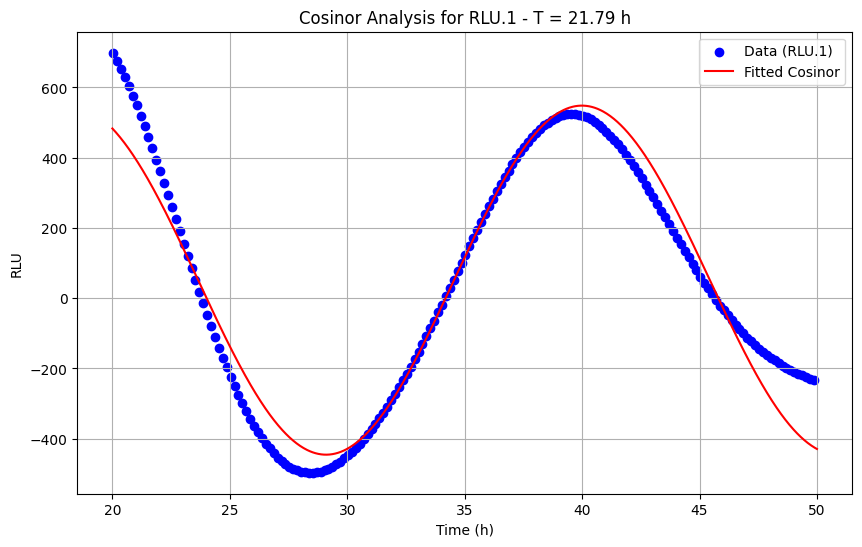

For RLU.2 (linear grid search): Refined T = 20.90 h, MESOR = 40.61, Amplitude = 422.86, Phase = 0.62
Nonlinear fit for RLU.2: T = 20.90 h, MESOR = 40.60, Amplitude = 422.89, Phase = 0.62


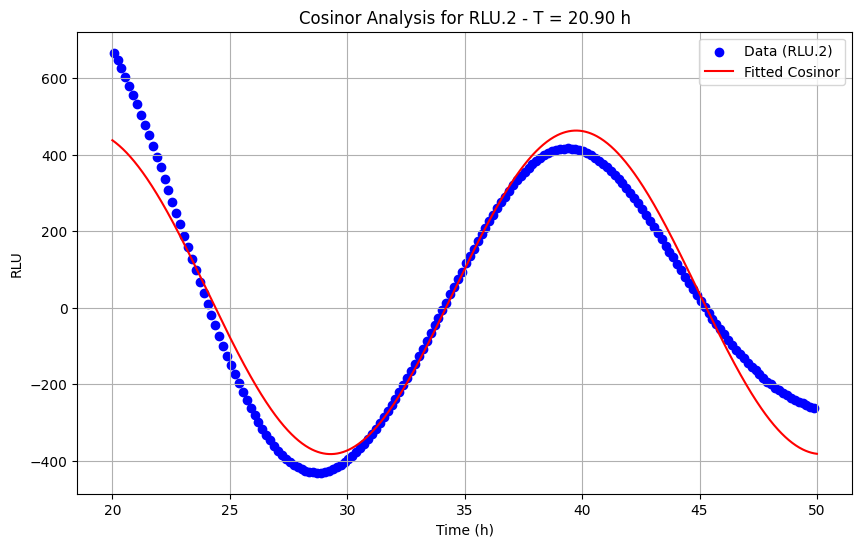

For RLU.3 (linear grid search): Refined T = 21.01 h, MESOR = 23.61, Amplitude = 441.82, Phase = 0.71
Nonlinear fit for RLU.3: T = 21.01 h, MESOR = 23.59, Amplitude = 441.86, Phase = 0.72


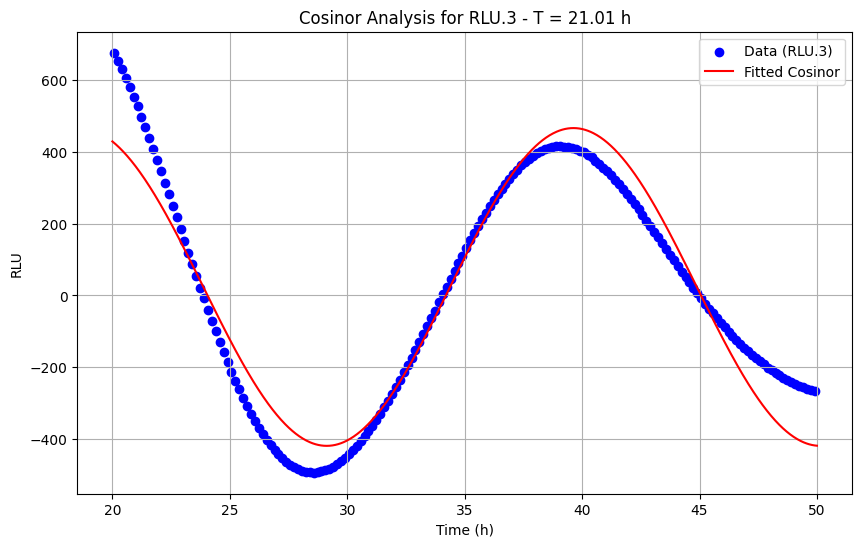

For RLU.4 (linear grid search): Refined T = 21.74 h, MESOR = -34.15, Amplitude = 966.37, Phase = 1.29
Nonlinear fit for RLU.4: T = 21.75 h, MESOR = -34.19, Amplitude = 966.41, Phase = 1.29


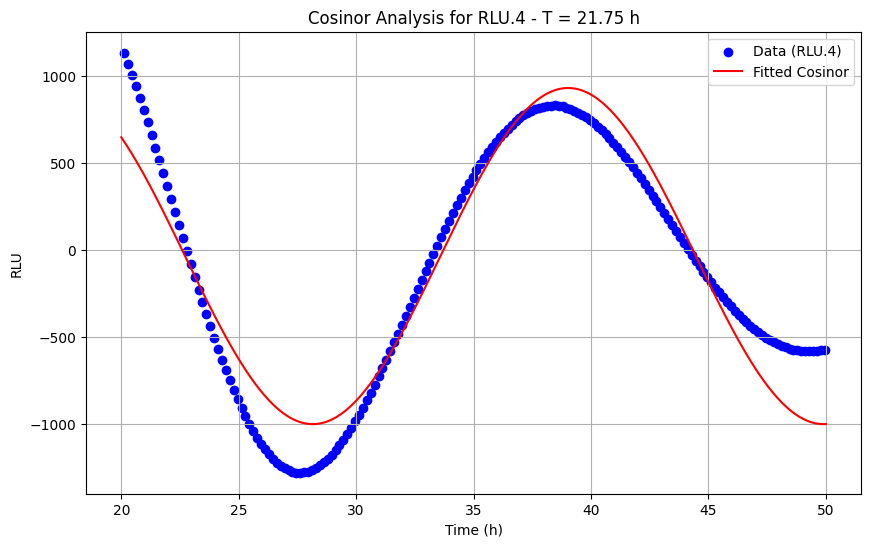

For RLU.5 (linear grid search): Refined T = 20.96 h, MESOR = 11.13, Amplitude = 880.02, Phase = 0.93
Nonlinear fit for RLU.5: T = 20.96 h, MESOR = 11.17, Amplitude = 879.96, Phase = 0.93


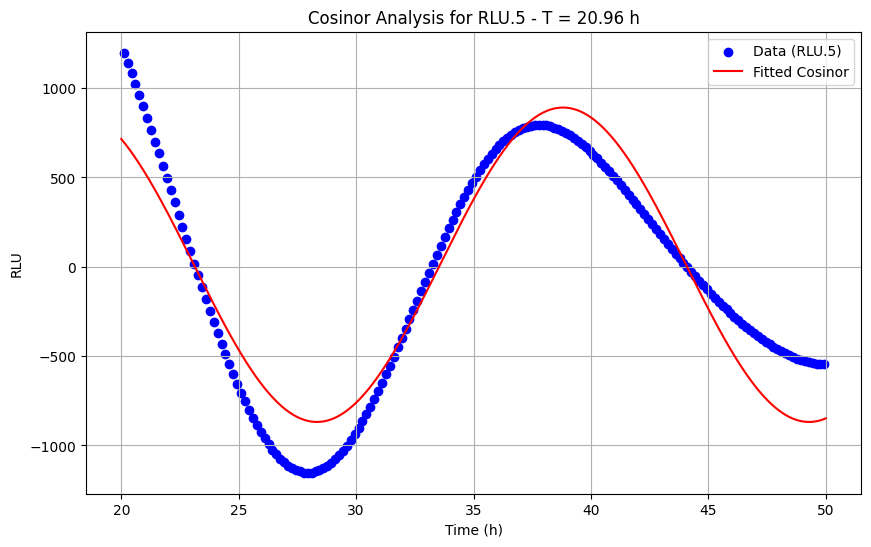

For RLU.6 (linear grid search): Refined T = 21.04 h, MESOR = 20.65, Amplitude = 1049.67, Phase = 0.85
Nonlinear fit for RLU.6: T = 21.04 h, MESOR = 20.64, Amplitude = 1049.70, Phase = 0.85


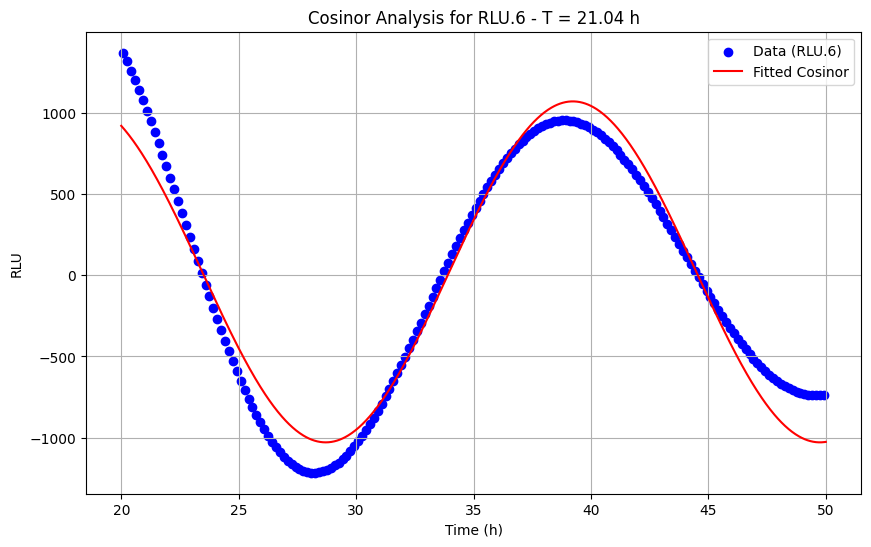

For RLU.7 (linear grid search): Refined T = 23.58 h, MESOR = -323.07, Amplitude = 973.18, Phase = 1.07
Nonlinear fit for RLU.7: T = 23.58 h, MESOR = -323.08, Amplitude = 973.18, Phase = 1.07


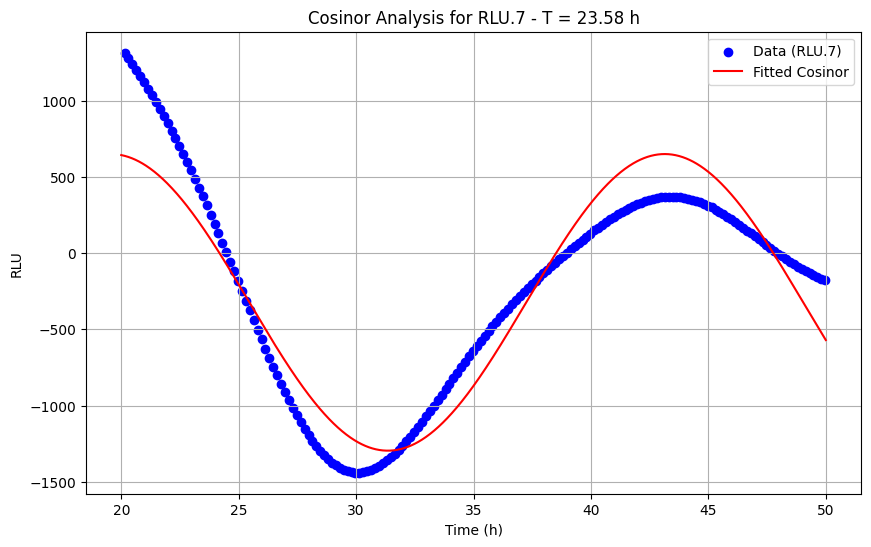

For RLU.8 (linear grid search): Refined T = 25.49 h, MESOR = -95.82, Amplitude = 357.25, Phase = 1.68
Nonlinear fit for RLU.8: T = 25.49 h, MESOR = -95.82, Amplitude = 357.25, Phase = 1.68


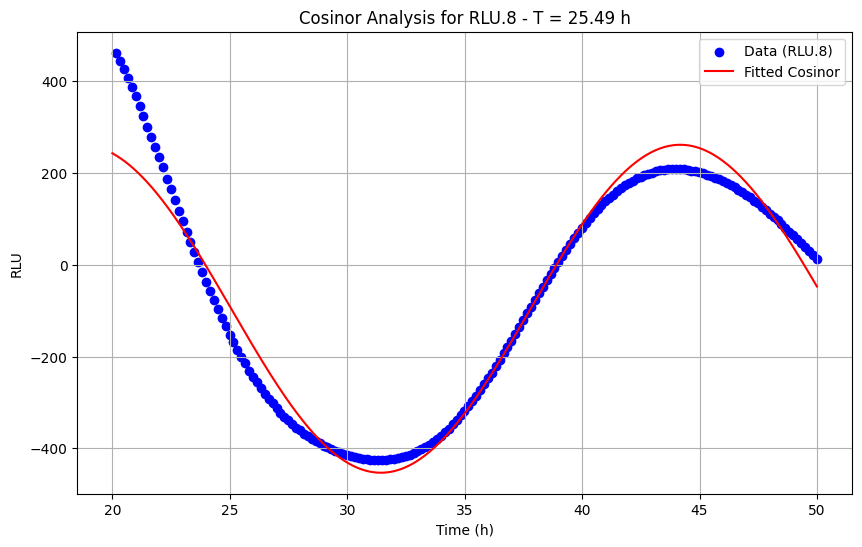

For Bottom (linear grid search): Refined T = 10.00 h, MESOR = 33.59, Amplitude = 0.42, Phase = -3.05
Nonlinear fit for Bottom: T = 10.00 h, MESOR = 33.59, Amplitude = 0.42, Phase = -3.05


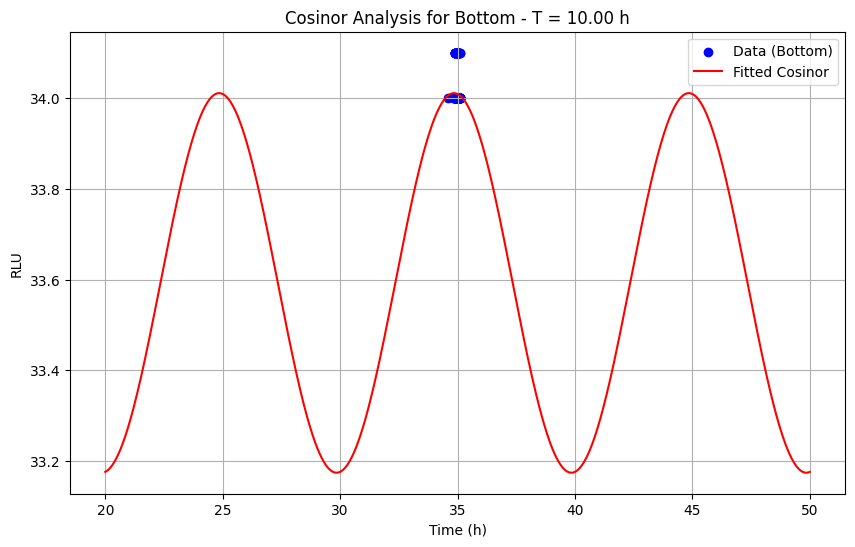

  Measurement        MESOR    Amplitude  Period (hours)  Phase (radians)
0         RLU  3689.945745   124.233553       48.000000         1.098870
1       RLU.1    51.381713   496.998186       21.789388         1.033725
2       RLU.2    40.602102   422.886875       20.902179         0.619125
3       RLU.3    23.593780   441.856713       21.013560         0.716088
4       RLU.4   -34.185065   966.411112       21.746998         1.290569
5       RLU.5    11.173218   879.958380       20.955052         0.929549
6       RLU.6    20.643776  1049.700535       21.041659         0.852965
7       RLU.7  -323.080228   973.180950       23.581748         1.072065
8       RLU.8   -95.818413   357.253913       25.492718         1.677543
9      Bottom    33.592587     0.418332       10.000000        -3.046643


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 非線形コサイナー解析モデルの定義（最終的な非線形フィッティング用）
def nonlinear_cosinor_model(t, mesor, amplitude, period, phase):
    return mesor + amplitude * np.cos((2 * np.pi * t / period) + phase)

# データの読み込み（ヘッダーが想定通りか確認）
csv_file_path = '/content/2025-0226-1339_Plate1_F0_N_D.csv'
data = pd.read_csv(csv_file_path, skiprows=11)

# 測定項目のペアを抽出（Time と RLU のカラムをペアに）
measurement_pairs = []
for i in range(1, len(data.columns) - 1, 2):
    time_col = data.columns[i]     # "Time(h)"
    rlu_col = data.columns[i+1]     # "RLU"
    measurement_pairs.append((time_col, rlu_col))

# 解析対象の時間帯
start_time = 20.0
end_time = 50.0

results = []  # 解析結果保存用リスト

for time_col, rlu_col in measurement_pairs:
    # 数値データへ変換
    time_data = pd.to_numeric(data[time_col], errors='coerce')
    rlu_data = pd.to_numeric(data[rlu_col], errors='coerce')

    # 指定した時間帯かつ有効な数値のみを抽出
    valid_indices = (time_data >= start_time) & (time_data <= end_time) & np.isfinite(rlu_data)
    t = time_data[valid_indices].values
    y = rlu_data[valid_indices].values

    if len(t) < 5:
        print(f"Not enough data for {rlu_col}")
        continue

    # ===== 1. 粗いグリッドサーチ =====
    T_grid_coarse = np.linspace(10, 48, 200)  # 10～48時間を200点で探索
    best_SSE = np.inf
    best_T = None
    best_coeffs = None

    for T in T_grid_coarse:
        # 線形化：y = MESOR + β cos(2πt/T) + γ sin(2πt/T)
        X1 = np.cos(2 * np.pi * t / T)
        X2 = np.sin(2 * np.pi * t / T)
        X = np.column_stack([np.ones_like(t), X1, X2])
        coeffs, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
        if residuals.size > 0:
            SSE = residuals[0]
        else:
            y_pred = X @ coeffs
            SSE = np.sum((y - y_pred) ** 2)

        if SSE < best_SSE:
            best_SSE = SSE
            best_T = T
            best_coeffs = coeffs

    # ===== 2. 細かいグリッドサーチ =====
    delta = 1.0  # ±1時間の範囲
    T_grid_fine = np.linspace(max(10, best_T - delta), min(48, best_T + delta), 200)
    best_SSE_fine = np.inf
    refined_T = best_T
    refined_coeffs = best_coeffs.copy()
    for T in T_grid_fine:
        X1 = np.cos(2 * np.pi * t / T)
        X2 = np.sin(2 * np.pi * t / T)
        X = np.column_stack([np.ones_like(t), X1, X2])
        coeffs, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
        if residuals.size > 0:
            SSE = residuals[0]
        else:
            y_pred = X @ coeffs
            SSE = np.sum((y - y_pred) ** 2)

        if SSE < best_SSE_fine:
            best_SSE_fine = SSE
            refined_T = T
            refined_coeffs = coeffs.copy()

    # refined_coeffs: [MESOR, beta, gamma]
    MESOR_est = refined_coeffs[0]
    beta_est = refined_coeffs[1]
    gamma_est = refined_coeffs[2]
    A_est = np.sqrt(beta_est**2 + gamma_est**2)
    phi_est = np.arctan2(-gamma_est, beta_est)

    print(f"For {rlu_col} (linear grid search): Refined T = {refined_T:.2f} h, MESOR = {MESOR_est:.2f}, Amplitude = {A_est:.2f}, Phase = {phi_est:.2f}")

    # ===== 3. 最終的な非線形フィッティング =====
    initial_guess = [MESOR_est, A_est, refined_T, phi_est]
    try:
        popt, pcov = curve_fit(
            nonlinear_cosinor_model, t, y,
            p0=initial_guess,
            bounds=(
                [-np.inf, 0, 10, -np.pi],
                [ np.inf, np.inf, 48,  np.pi]
            ),
            maxfev=20000,
            method='trf'
        )
    except RuntimeError as e:
        print(f"Nonlinear fit failed for {rlu_col}: {e}")
        continue

    MESOR_fit, A_fit, T_fit, phi_fit = popt
    # ===== acrophase の計算 =====
    # acrophase = (-phi * T) / (2π)  mod T
    acrophase = (-phi_fit * T_fit / (2 * np.pi)) % T_fit

    print(f"Nonlinear fit for {rlu_col}: T = {T_fit:.2f} h, MESOR = {MESOR_fit:.2f}, Amplitude = {A_fit:.2f}, Phase = {phi_fit:.2f}, Acrophase = {acrophase:.2f} h")

    # ===== プロット =====
    t_range = np.linspace(start_time, end_time, 1000)
    plt.figure(figsize=(10, 6))
    plt.scatter(t, y, label=f'Data ({rlu_col})', color='blue')
    plt.plot(t_range, nonlinear_cosinor_model(t_range, MESOR_fit, A_fit, T_fit, phi_fit),
             'r-', label='Fitted Cosinor')
    plt.title(f'Cosinor Analysis for {rlu_col} - T = {T_fit:.2f} h')
    plt.xlabel('Time (h)')
    plt.ylabel('RLU')
    plt.legend()
    plt.grid(True)
    plt.show()

    results.append({
        'Measurement': rlu_col,
        'MESOR': MESOR_fit,
        'Amplitude': A_fit,
        'Period (hours)': T_fit,
        'Phase (radians)': phi_fit,
        'Acrophase (hours)': acrophase
    })

# ===== 結果の表示 =====
results_df = pd.DataFrame(results)
print(results_df)
